# Computational Discrete-state Dynamic Programming for the Simple Deterministic Problem



## Introduction 
Suppose we want to solve the growth problem with the Bellman equation for the optimal growth model
$$
v(k) = max[u(f(k) - x) +  v(x) ]
$$
where $x$ denotes the capital stock chosen for next period

For this problem the givens are<br>
– state space $\mathcal{K}$<br>
– strictly increasing strictly concave production function $f(k)$<br>
– strictly increasing strictly concave utility function $u(c)$<br>
– constraint sets of the form $\Gamma(k) = [0, f(k)]$ for each $k \in \mathcal{K}$<br>
– time discount factor $0 < \beta  < 1$


## Table of contents
1. [Deterministic dynamic programming](#1)<br>
    1.1 [A Growth Model](#11)<br>
    1.2 [Dynamic Programming](#12)<br>
    1.3 [Simple deterministic model](#13)<br>
    1.4 [Discrete state space approximation](#14)<br>
2. [Solution Algorithms](#2)<br>
    2.1 [Value iteration](#21)<br>
    2.2 [Policy iteration](#22)<br>
    2.3 [Modified policy iteration](#23)<br>
3. [Summary](#3)<br>
4. [References](#4)<br>

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from time import time
from functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

from codes.ddp_auxiliary import *
from codes.ddp_plots import *
from codes.ddp_algorithms import modified_policy_iteration
from codes.ddp_algorithms import policy_iteration
from codes.ddp_algorithms import value_iteration
from codes.ddp_algorithms import bellman_equation
from codes.ddp_algorithms import evaluate_policy

## I. Deterministic dynamic programming <a id="1"></a>

### 1.1 A growth model <a id="11"></a>

Suppose the economy has a constant population of a large number of identical agents. In period t, our agent derives utility $u(c_t)$ from consumption $c_t$. Utility is discounted at rate $\beta \in (0, 1)$. So period $t$ utility is discounted to period $0$ as $\beta^t u(c_t)$. 
- We are consider the following *sequence problem*

$$ \max\limits_{c_t,k_{t+1}}\sum_{t=0}^{\infty} \beta^t u(c_t) \qquad 0<\beta<1 \qquad \qquad (S) $$

subject to a sequence of *constraint sets*
$$ k_{t+1} \in \Gamma (k_t)$$
and given initial condition
$$ k_0 \in \mathcal{K}$$
- Corresponding to this is the recursive problem

$$
 v(k_t) = \sup\limits_{k_{t+1} \: \in \: \Gamma(k)} F(k_t, k_{t+1}) + v(k_{t+1}) \qquad for \: all \: k_{t+1} \in \mathcal{K} \qquad \qquad (R)
 $$
### 1.2 Dynamic Programming <a id="12"></a>
Let consider how Bellman equation can solve the original sequence problem
- General idea is that<br>
(i) solution $v$ to $(R)$ evaluated at $k = k_0$ gives the sup in $(S)$, and <br>
(ii) a sequence $\{x_{t+1}\}_{t=0}^\infty$ attains the sup in $(S)$ if and only if
$v(k_t) = F(k_t, k_{t+1}) + \beta v(k_{t+1}), \qquad t = 0, 1, 2,...n $

Bellman called this general idea the *Principle of Optimality*
#### The Bellman Equation
A recursive representation like
$$ v(k) = \max\limits_{x} [u(f(k), x) + \beta v(x)] $$
where $x$ denotes the capital stock chosen for next period


#### Value function
Let $v(k_0)$ denote the maximized objective function
$$ 
v(k_0) = \max\limits_{\{k_{t+1}\}_{t= 0}^\infty} \:\: \sum_{t=0}^{\infty} \beta^t[u(f(k_t), x)] \qquad 0 < \beta < 1
$$

#### Policy function
The policy function in this dynamic programming problems: 

$$g(k) = \underset{x}{argmax}[u(f(k),x) +\beta v(x)] $$

Iterating on the policy function gives the sequence of capital stocks

$$ \begin{array}{c} k_1 = g(k_0) \\
k_2 = g(k_1) = g(g(k_0)) \\
 .\\
 .\\
 .\\
 k_{t+1} = g(k_t) = g^t(k_0)
 \end{array} 
 $$
 
Properties of $g(k)$ determine the properties of the optimal sequence of $k_t$. Steady states satisfy $k^* = g(k^*)$. A steady state is locally
stable if $|g'(k^*)| < 1$ and so on


### 1.3 A simple deterministic model <a id="13"></a>
In order to better understand the algorithm, let consider a simple example of deterministic inﬁnite-horizon Ramsey Model with
$$ u(c) = \frac{c^{1-\sigma} -1}{1 - \sigma}$$
and
$$ k^{\prime} = k^\alpha - c - (1-\delta) k$$


In [2]:
paras = {
    'beta': 0.95,
    'alpha': 0.3,
    'delta': 0.1,
    'sigma': 2,
}

####  The optimal solution

In steady state, $ c^* = c $. This occurs where $ k^* = k$ :

$$ k^* = \left( \frac{\alpha}{\frac{1}{\beta} - (1 - \delta)} \right)^{\frac{1}{1-\alpha}} $$
$$ c^* = (k^*)^\alpha - \delta k^*$$

In [3]:
capitals, consumptions, A = linearized_dynamic_system(**paras)
print("The optimal solution at steady state: \n    Capitals is {:.5}.\n    Consumption is {:.5}".format(capitals,consumptions))

The optimal solution at steady state: 
    Capitals is 2.6257.
    Consumption is 1.0733


### 1.4 Discrete state space approximation <a id="14"></a>

- Now suppose we approximate the continuous state space $\mathcal{K}$ with a suitably chosen ﬁnite grid of possible capital stocks 

$$ \mathcal{K} = \{k_1,. . . , k_i, . . . , k_n\} \qquad i = 1, ..., n $$
In this notebook, I use the  equally spaced approach, which is to choose an equally spaced grid in each dimension of the single state space and then form the Cartisian product of the state grids. This approach has the problem, that the set of grid points grows exponentially in the grid points of the single state directions and this is called the *Curse of Dimensionality* and is maybe the major drawback of *Dynamic Programming* .

- Let $c_{ij}$ denote consumption if current capital is $k = k_i $ and capital chosen for next period is $x = k_j$

$$c_{ij} = f(k_i) +\delta(1 - k_i) - k_j \qquad i, j = 1, ..., n $$

- So u is an $n \times n$ matrix with rows indicating current capital $k = k_i$ and columns indicating feasible choices for $x = k_j$
$$u_{ij} = u(c_{ij})$$
- Our Bellman equation can be written
$$v_i = \max\limits_{j} [u_{ij} +  \beta v_j] \qquad i = 1, ..., n$$

- Associated to this is the policy function
$$g_i = \underset{j}{argmax}[u_{ij} +  v_j] \qquad i = 1, ..., n $$
such that $g_i = g(k_i)$ attains the max given $k = k_i$

In [4]:
#Choosing the number of points of the grid and the maximum iteration times
max_iter, num_states= 500, 400

# Create grid world
k_grid, c_grid, u_grid =  get_grid(dev = None, num_states = num_states, **paras)

 Linearly approximated captial stock through time


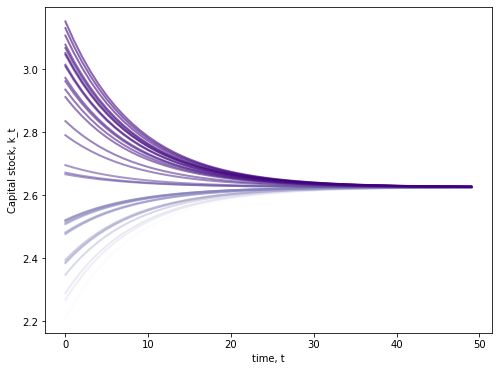

In [5]:
#Choosing T periods to simulate and the number of lines with various ko
T, lines = 50, 30

k_sim, c_sim = linear_solution(k_grid , T , **paras)
plot_transition_dynamics(range(T), k_sim, num_states, lines)

## II. Solution Algorithms <a id="2"></a>
The previous section lays out the theoretical foundation of dynamic programming. The goal of this section is to show how we can solve practically
$$
v_i = \max\limits_j[u_{ij} +  v_j], \qquad i = 1, ..., n
$$

There are three widely used computational methods for solving dynamic programming problems

In [6]:
METHODS = ["Value-iteration", "Policy-iteration", "Modified-policy-iteration"]
df_iter = pd.DataFrame(columns=["Iteration"], index=METHODS)
df_iter.index.name = "Method"

### 2.1. Value iteration <a id="21"></a>


#### Outline of the algorithm:

- *Step 1:* Choose a convergence criterion $\epsilon$ for $||v_i(k) − v_{i−1}(k)|| < \epsilon $

- *Step 2:* Start with an initial guess for the value function $v_0(k)$, e.g. $v_0(k) =0$ then calculate
$$ v_i^1 = Tv_i^0 = max[u_{ij} + \beta v_j^0], \qquad i = 1, ..., n  $$

- *Step 3:* Compute the error
$$ \|Tv^0 - v^0\| = \max\limits_{i} [|Tv_i^0 - v_i^0|]$$

- *Step 4:* If this error is less than some pre-speciﬁed tolerance $\epsilon > 0$, stop. Otherwise, keep iterating on
$$v_{i}^{l+1} = Tv_{i}^l = \max\limits_{j}[u_{ij} +  v_j^l], \qquad i = 1, ..., n $$

The number of iteration is 210
Drawing 30 random lines of value function iteration and the final value function


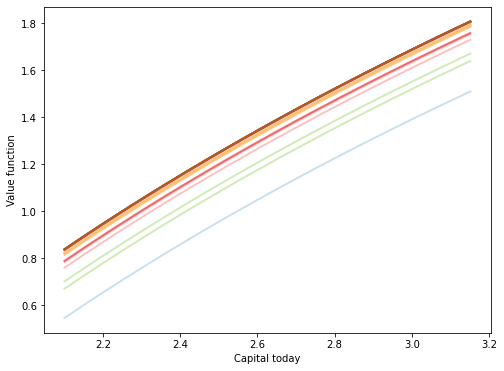

In [8]:
crit = 1e-06
value_store_iter_v, store_policy_v, num_iter_v = value_iteration(crit, max_iter, u_grid, paras["beta"])
print("The number of iteration is {}".format(num_iter_v))
df_iter.loc["Value-iteration","Iteration"] = num_iter_v

draw_lines = 30
print("Drawing {} random lines of value function iteration and the final value function".format(draw_lines))
plot_value_iteration(k_grid, value_store_iter_v, num_iter_v, draw_lines)

## 2.2. Policy iteration <a id="22"></a>

The advantage of the policy function iteration algorithm is that it in general converges faster. If it converges faster than the value function iteration algorithm depends on the modulus of the contraction mapping. If it is close to one the policy function iteration is much faster, but the time advantage decreases with decreasing modulus and the value function iteration might even become faster, as it does not require any matrix inversion

**Howard improvement algorithm**

- *Step 1:*  Start with an initial guess for the policy function, which is feasible. Derive the implied transition function $Q(.)$.

- *Step 2:* Policy Improvement <br>
Choose for every $k$:
$$v_i = \max\limits_{j} [u_{ij} +  \beta v_j] $$
and 
$$g_i = \underset{j}{argmax}[u_{ij} +  v_j] $$

- *Step 3:* Policy Evaluation <br>
Each time a policy function hs is computed, we solve for the value function that would occur, if the policy were followed forever. This value
function is then used in the next step to obtain a new policy function with solution. We introduce a matrix $Q$ with zeros everywhere except for its row i and column j elements, which equal one. The above equations may then be written as 
$$v = u + \beta Q v $$
But this can be easily solved for $v(x)$
$$v = [I − \beta Q]^{−1}u$$

- *Step 4:* Check convergence. If the policy function has not yet converged go back to step 2.

The number of iteration is 18


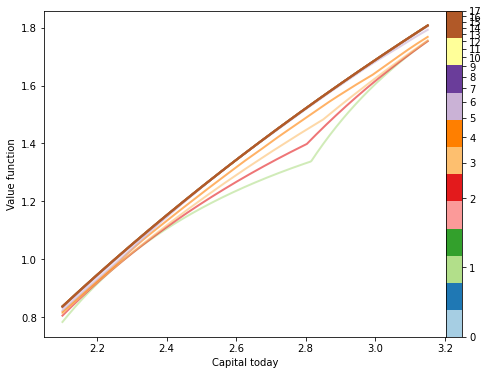

In [11]:
value_store_iter_p, store_policy_p, num_iter_p = policy_iteration(max_iter, u_grid, paras["beta"])
print("The number of iteration is {}".format(num_iter_p))
df_iter.loc["Policy-iteration","Iteration"] = num_iter_p
plot_policy_iteration(k_grid, value_store_iter_p, num_iter_p)

## 2.3. Modified policy iteration <a id="23"></a>

If it is not possible to implement the solution of the large linear system or if it becomes too time consuming to solve this
system, there is an alternative to full policy iteration. Modiﬁed policy iteration with $n$ steps computes the value function v1 at the end of Step 3

$$ v_i^j(k) = u(c_i(k), x) +  E[v_i^{j-1}(c_i(k), k)] $$
if $j = N$ stop and set $v_{i+1}(k) = v_i^N(k)$.

The number of the updating steps N can be choosen arbirarily. $n$ steps between 15 and 30 depending on the problem, turned out to yield the best time-speed trade-oﬀ.

The number of iteration is 17


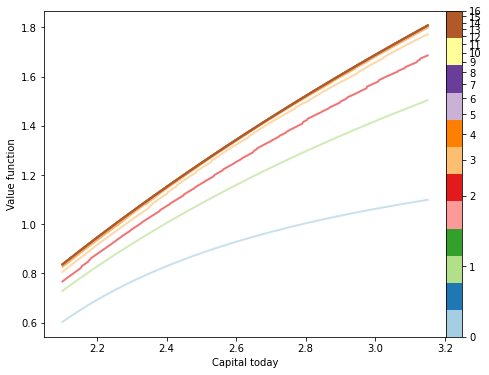

In [13]:
k = 30 #the number of updating step
value_store_iter_m, store_policy_m, num_iter_m = modified_policy_iteration(crit, k, max_iter, u_grid, paras["beta"])
print("The number of iteration is {}".format(num_iter_m))
df_iter.loc["Modified-policy-iteration","Iteration"] = num_iter_m
plot_policy_iteration(k_grid, value_store_iter_m, num_iter_m)

## III. Summary <a id="3"></a>

### 3.1 Visualize Bellman operator <a id="31"></a>

First, plot two random utility lines in relation with capital stock $k_t$ and the choice of next capital stock $k_{t+1}$

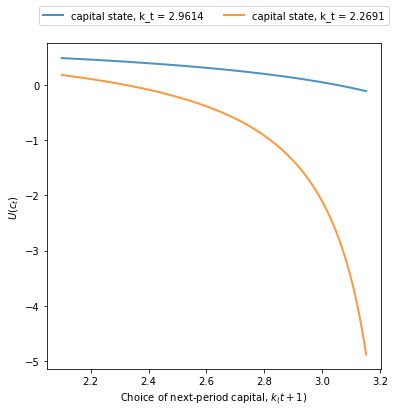

In [14]:
plot_capital_current_utility(u_grid, k_grid)

Plot the total of the objective on the right-hand-side of Bellman equation

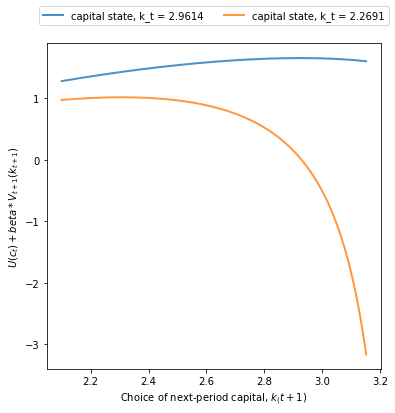

In [15]:
plot_bellman_equation(u_grid, k_grid, paras["beta"], value_store_iter_v, num_iter_v)

### 3.2 Iterations and running time of three methods <a id="32"></a>

#### Comparing the number of iteration

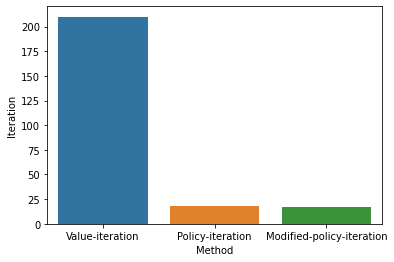

In [16]:
_ = sns.barplot(x="Method", y="Iteration", data=df_iter.reset_index())

#### Comparing running time

In [15]:
n = 30 # n times looping
ITERS = ["iter_{}".format(i) for i in range(n)]
df_runtime = pd.DataFrame(columns=ITERS, index=METHODS)
df_runtime.index.name = "Method"

In [17]:
runtime_value = partial(value_iteration, crit)
runtime_policy = partial(policy_iteration)
runtime_modified_policy = partial(modified_policy_iteration, crit, k)
runtime_list = [runtime_value, runtime_policy, runtime_modified_policy]

for i, f in enumerate(runtime_list):
    runtimes = []
    for _ in range(n):
        start = time()
        f(max_iter, u_grid, paras["beta"])
        stop = time()
        runtimes.append(stop - start)
    df_runtime.iloc[i] = runtimes

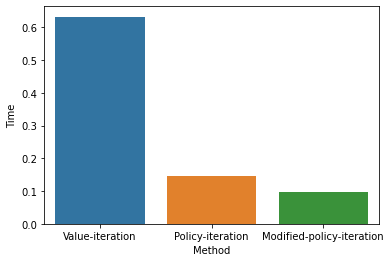

In [18]:
df = pd.DataFrame(df_runtime.mean(axis=1))
df.rename(columns={0:"Time"}, inplace=True)

_ = sns.barplot(x="Method", y="Time", data=df.reset_index())

## VI. References <a id="4"></a>


### Books

* Linge, Svein, Langtangen, Hans Petter (2016). [*Programming for Computations - Python*](https://www.springer.com/gp/book/9783319812823#aboutAuthors). Springer International Publishing.


### Papers
* Heer Burkhard & Maußner Alfred, 2011. [Value Function Iteration as a Solution Method for the Ramsey Model](https://ideas.repec.org/a/jns/jbstat/v231y2011i4p494-515.html). Journal of Economics and Statistics (Jahrbuecher fuer Nationaloekonomie und Statistik), De Gruyter, vol. 231(4), pages 494-515, August.

* Moritz Kuhn (2006). [Notes on Numerical Dynamic Programming in
Economic Applications](https://www.wiwi.uni-bonn.de/kuhn/notes/dpnotes.pdf).

### Lecture Notes
* Chris Edmond (2019) [Macroeconomics (PhD core), 2019](http://www.chrisedmond.net/phd2019.html)
* Thomas Hintermaier [Lecture in Macroeconomics (Master), 2019]